In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import os
import glob
from typing import Dict

In [2]:
def _get_metrics_from_tensorboard(event_acc, scalar):
    train_metrics, val_metrics = event_acc.Scalars(f'{scalar}/train'), event_acc.Scalars(f'{scalar}/valid')
    train_df, val_df = pd.DataFrame(train_metrics), pd.DataFrame(val_metrics)

    train_df.drop(columns=['wall_time'], inplace=True)
    val_df.drop(columns=['wall_time'], inplace=True)

    train_df.rename(columns={'value': f'train_{scalar}'}, inplace=True)
    val_df.rename(columns={'value': f'val_{scalar}'}, inplace=True)
    results = pd.merge(train_df, val_df, on='step', how='outer')
    results = results.dropna()
    results = results.drop(columns=['step'])
    return results


def tensorboard_results(log_dir, experiment_name):
    events = EventAccumulator(log_dir)
    events.Reload()

    loss, acc, prec, rec = (
        _get_metrics_from_tensorboard(events, 'loss_e'),
        _get_metrics_from_tensorboard(events, 'acc'),
        _get_metrics_from_tensorboard(events, 'prec'),
        _get_metrics_from_tensorboard(events, 'rec')
    )

    results = [
        loss,
        acc,
        prec,
        rec
    ]


    return pd.concat(results, axis=1)

def top_metrics(results):
    metric_container = []
    for experiment_name, df in results.items():
        metric_container.append(_best_metrics(df, experiment_name))
    
    return pd.DataFrame(metric_container)

def _best_metrics(df, name):

    # last row from columns
    return {
        
        'Experiment': name,
        'BCE Loss': df['val_loss_e'].iloc[-1].round(4),
        'Accuracy': df['val_acc'].iloc[-1].round(4),
        'Precision': df['val_prec'].iloc[-1].round(4),
        'Recall': df['val_rec'].iloc[-1].round(4),
    }


def tensorboard_matrix(log_matrix: Dict):
    results_matrix = {}
    for k, v in log_matrix.items():
        print(f'Processing {k}')
        results_matrix[k] = tensorboard_results(v, k)
    
    for k, v in results_matrix.items():
        v.to_csv(f'result_csv/results_{k}.csv')

 
def bce_graph():
    path = 'result_csv'
    files = glob.glob(os.path.join(path, '*.csv'))
    bce_matrix = {}
    files = [f for f in files if 'embedding' in f]
    for f in files:
        df = pd.read_csv(f)
        df = df.drop(columns=['Unnamed: 0'])
        bce_matrix[f.split('/')[-1].split('.')[0]] = df[['train_loss_e', 'val_loss_e']]
    fig, ax = plt.subplots(2, 1, figsize=(20, 20))
    
    ax = ax.flatten()
    fig.suptitle('Binary Cross Entropy Loss Across Experiments', fontsize=20)
    for k, v in bce_matrix.items():
        fig_train = sns.lineplot(v['train_loss_e'], ax=ax[0], label=f'BCE Loss for {k}')
        fig_train.set(xlabel='Epochs', ylabel='Training BCE Loss')
        
        fig_val = sns.lineplot(v['val_loss_e'], ax=ax[1], label=f'BCE Loss for {k}')
        fig_val.set(xlabel='Epochs', ylabel='Validation BCE Loss')
        
        fig_train.set_title('Training BCE Loss Across Experiments', fontsize=15)
        fig_val.set_title('Validation BCE Loss Across Experiments', fontsize=15)

In [5]:
seq_1_001 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_1/data_partition_None/2023_05_03_11_10/version_0'

seq_10_001 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_10/data_partition_None/2023_04_28_19_18/version_0/'

seq_20_001 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_20/data_partition_None/2023_04_28_23_06/version_0'

seq_20_01 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_20/data_partition_None/2023_04_29_11_43/version_0'

seq_30_001 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_30/data_partition_None/2023_04_30_15_57/version_0'

seq_30_01 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_30/data_partition_None/2023_04_30_10_17/version_0'

seq_40_001 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_40/data_partition_None/2023_05_01_07_09/version_0'

seq_30_heuristic = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal_heuristic/sequence_length_30/data_partition_None/2023_05_09_16_15/version_0'

embedding_30 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/embedded_ordinal/sequence_length_30/data_partition_None/2023_05_10_07_25/version_0'

embedding_40_user = None
embedding_40_user_project = None

seq_container = {
    # "seq_1_001": seq_1_001,
    # "seq_10_001": seq_10_001,
    # "seq_20_001": seq_20_001,
    # "seq_30_001": seq_30_001,
    # "seq_40_001": seq_40_001,
    # "seq_30_heuristic": seq_30_heuristic,
    "embedding_30": embedding_30,
}



In [6]:
results = tensorboard_matrix(seq_container)

Processing embedding_30


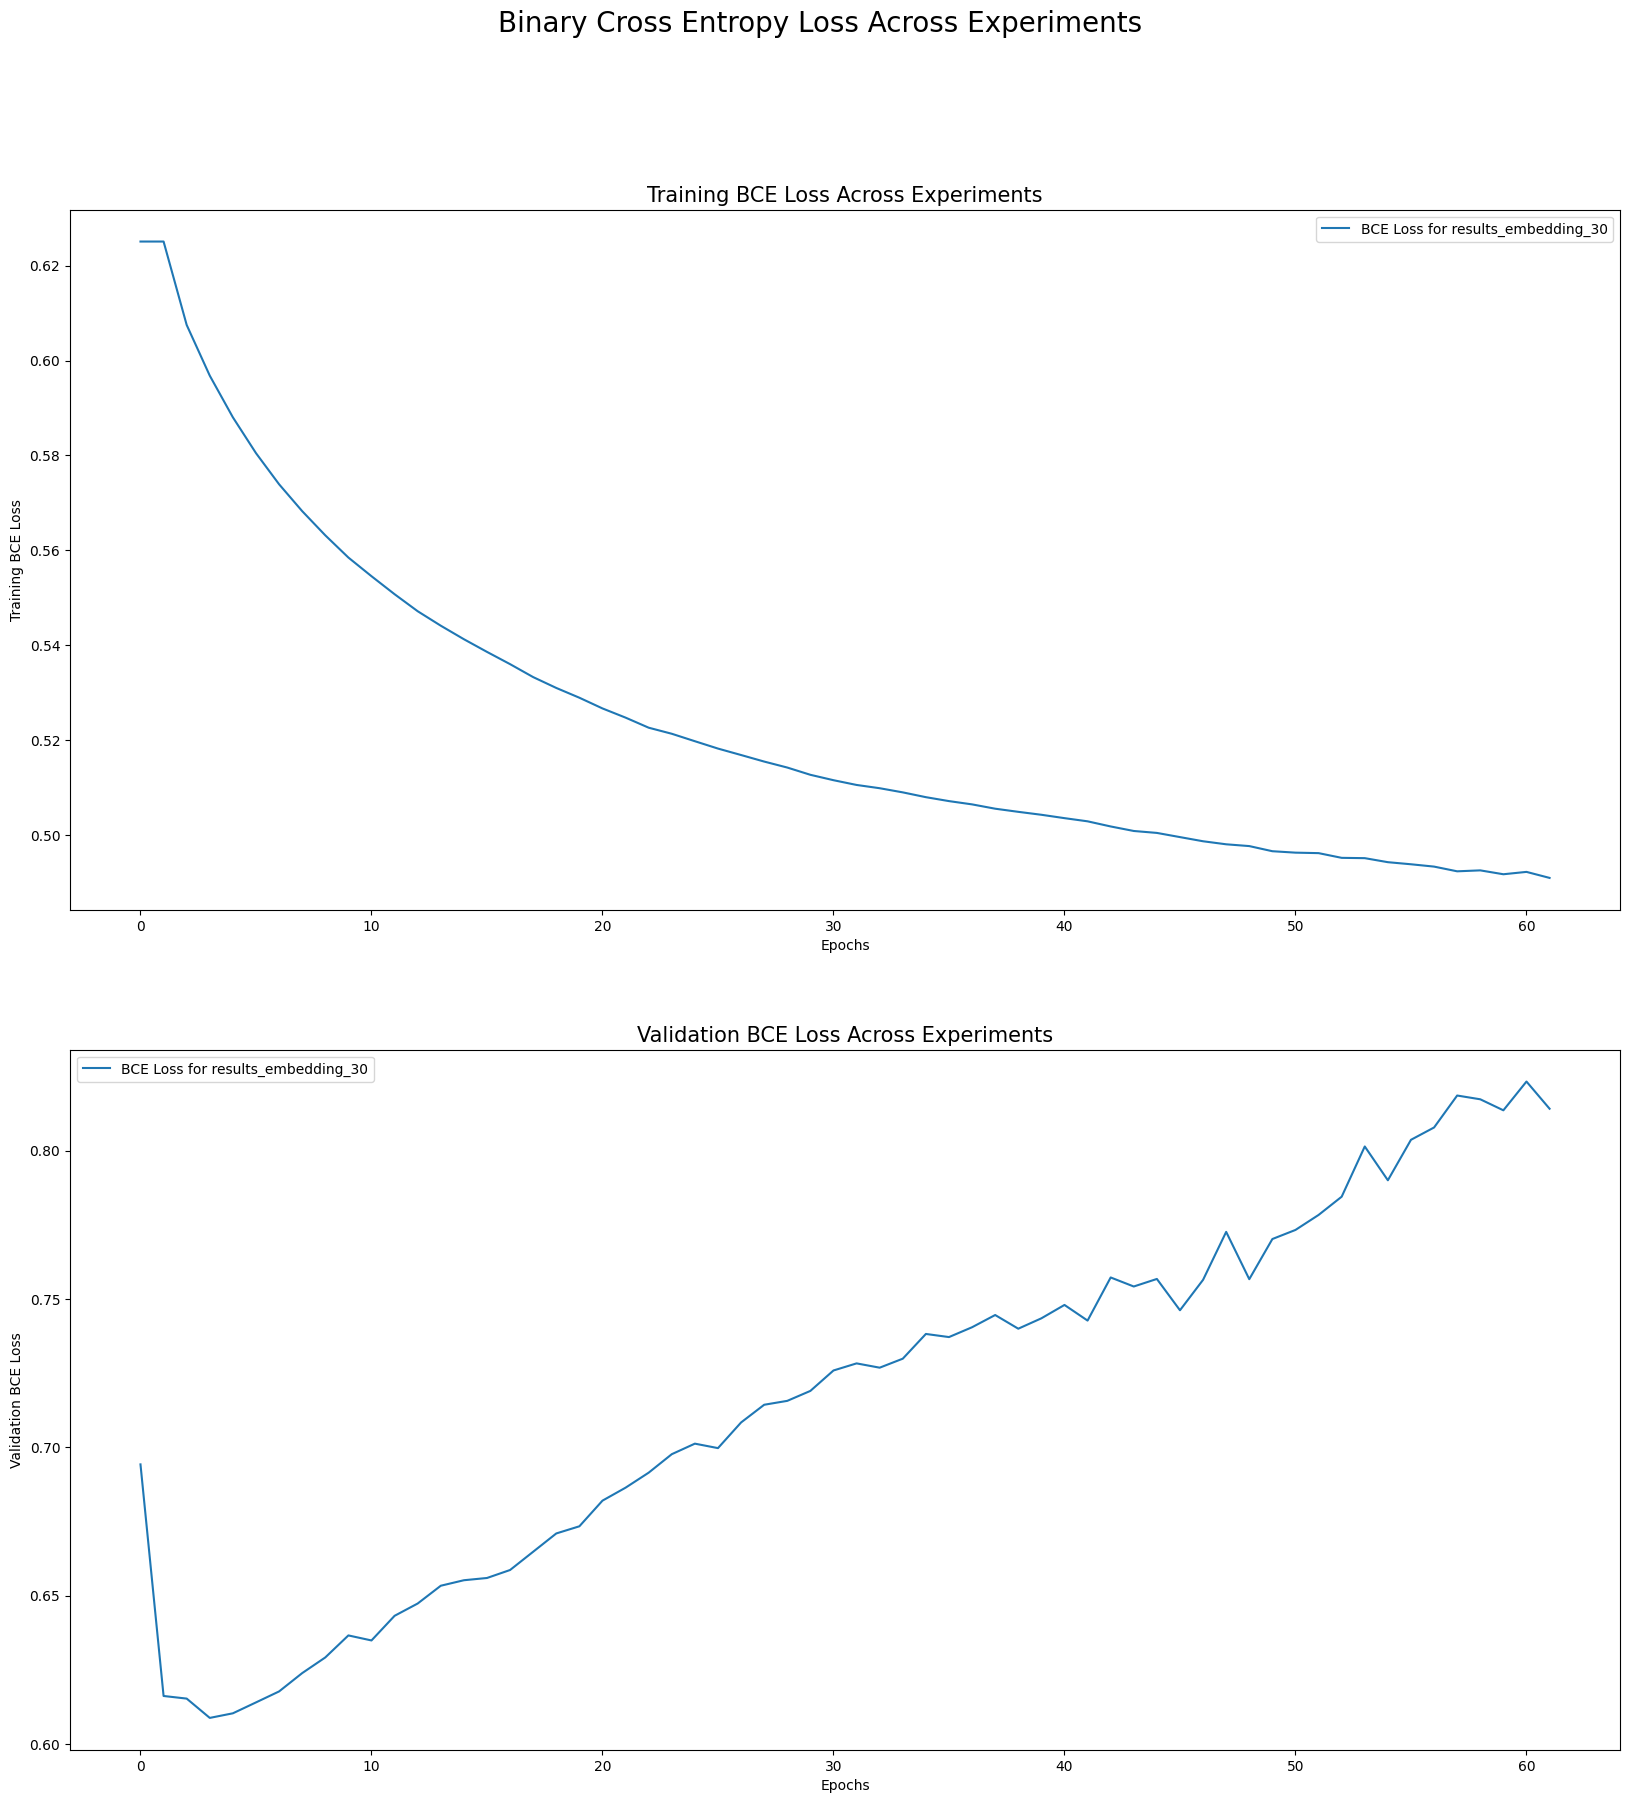

In [7]:
bce_graph()

In [9]:
result_files = glob.glob('result_csv/*.csv')
results = {}
for f in result_files:
    if 'embedding' in f:
        results[f.split('/')[-1].split('.')[0]] = pd.read_csv(f)

metrics = top_metrics(results)

In [14]:
metrics['Experiment'] = metrics['Experiment'].str.replace('_', ' ')

In [10]:
metrics.sort_values(by=['Experiment'])

,Experiment,BCE Loss,Accuracy,Precision,Recall
0,results_embedding_30,0.8141,0.587,0.5459,0.3418


In [11]:
print(metrics.to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Experiment & BCE Loss & Accuracy & Precision & Recall \\
\midrule
results_embedding_30 & 0.814100 & 0.587000 & 0.545900 & 0.341800 \\
\bottomrule
\end{tabular}

